# Access AWS CESM2 using the AWS open data origin data 

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
import re
# import nest_asyncio
# nest_asyncio.apply()
import aiohttp

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
#
rda_url    =  'https://data.rda.ucar.edu/'
intake_url = rda_url + 'harshah/intake_catalogs/cesm2-lens-osdf/aws-cesm2-le.json'

In [6]:
# # Spin up SLURM cluster
#job_extra = ['--qos=icx','--account=ac_cumulus'] 
cluster =  SLURMCluster(queue="icx", cores=5, walltime='6:00:00', 
                local_directory='/home1/10234/hhampapura/dask_space/', 
                log_directory='/home1/10234/hhampapura/dask_space/', memory ="192GB")
                #job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

2024-10-09 22:18:30,894 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x14c6f0d2e370>>, <Task finished name='Task-32' coro=<SpecCluster._correct_state_internal() done, defined at /home1/10234/hhampapura/.local/lib/python3.9/site-packages/distributed/deploy/spec.py:346> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: 1\nCommand:\nsbatch /tmp/tmp90uvwwy7.sh\nstdout:\n\n[TACC]: Job submission is not allowed from this host. Please submit\n[TACC]: through one of the available login resources.\n\n\nstderr:\n\n')>)
Traceback (most recent call last):
  File "/home1/10234/hhampapura/.local/lib/python3.9/site-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
  File "/home1/10234/hhampapura/.local/lib/python3.9/site-packages/tornado/ioloop.py", line 774, in _discard_future_result
    future.result()
  File "/home1/10234

### Access the data from the AWS bucket using intake

In [6]:
osdf_catalog = intake.open_esm_datastore(intake_url)
osdf_catalog

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [7]:
osdf_catalog.df['path'].head().values

array(['osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLNSC.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FLUT.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNS.zarr',
       'osdf:///aws-opendata/us-west-2/ncar-cesm2-lens/atm/daily/cesm2LE-historical-cmip6-FSNSC.zarr'],
      dtype=object)

In [8]:
osdf_catalog_temp = osdf_catalog.search(variable ='TREFHTMX', frequency ='daily')
osdf_catalog_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [17]:
%%time
#dsets = osdf_catalog_temp.to_dataset_dict(storage_options={'anon':True})
dsets = osdf_catalog_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


CPU times: user 541 ms, sys: 29.5 ms, total: 570 ms
Wall time: 10 s


In [18]:
dsets.keys()

dict_keys(['atm.ssp370.daily.smbb', 'atm.historical.daily.smbb', 'atm.historical.daily.cmip6', 'atm.ssp370.daily.cmip6'])

In [19]:
historical_smbb = dsets['atm.historical.daily.smbb']
historical_smbb

<xarray.Dataset> Size: 666GB
Dimensions:    (member_id: 50, time: 60225, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1191p1f2' ... 'r9i1171p1f2'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, nbnd) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHTMX   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...
    ...                                ...
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:path:             osdf:///aws-opendata/us-west-2/ncar-ce...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.daily.smbb

In [20]:
%%time
historical_smbb.TREFHTMX.isel(member_id=0,time=0)

CPU times: user 675 µs, sys: 0 ns, total: 675 µs
Wall time: 684 µs


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288)> Size: 221kB
dask.array<getitem, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1191p1f2'
    time       object 8B 1850-01-01 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

CPU times: user 396 ms, sys: 173 ms, total: 570 ms
Wall time: 1.29 s


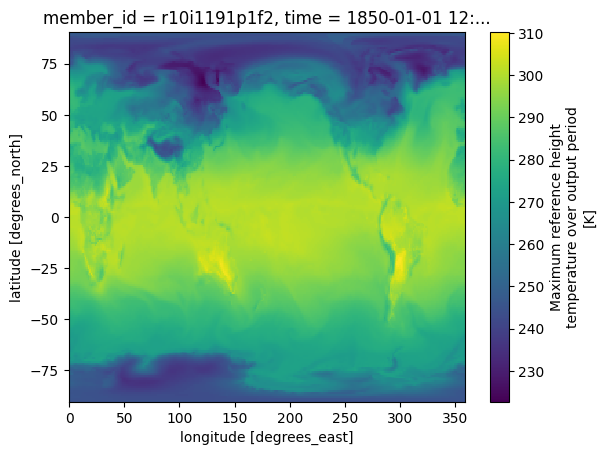

In [21]:
%%time
historical_smbb.TREFHTMX.isel(member_id=0,time=0).plot()